# This notebook is about feature engineering with sentiment analysis and classification

#### Load useful libraries and df

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


from tqdm import tqdm

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/janice/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/janice/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
df = pd.read_csv("../data/chatgpt_short_clean_combined_en.csv", 
                 parse_dates=["at", "repliedAt"])

In [3]:
df.shape

(27922, 21)

In [4]:
from transformers import pipeline
#import torch

In [5]:
classifier = pipeline("zero-shot-classification")

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [6]:
#candidate_labels = ["feature evaluation", "praise", "bug report", "feature request", "performance", "usage"]
candidate_labels = ["positive", "neutral", "negative"]
hypothesis_template = "The sentiment of this review is {}."

In [7]:
#candidate_labels = list(category_map.values())
predictedCategories = []
ScoreNegative = []
ScoreNeutral = []
ScorePositive = []

for i in tqdm(range(len(df))): # len(df)
    text = df.iloc[i,]['content']
    res = classifier(text, candidate_labels, hypothesis_template=hypothesis_template, multi_label=True)
    labels = res['labels'] 
    scores = res['scores'] #extracting the scores associated with the labels
    res_dict = {label : score for label,score in zip(labels, scores)}
    sorted_dict = dict(sorted(res_dict.items(), key=lambda x:x[1],reverse = True)) #sorting the dictionary of labels in descending order based on their score
    categories  = next(k for i, (k,v) in enumerate(sorted_dict.items()))

    ScorePositive.append(sorted_dict['positive'])
    ScoreNeutral.append(sorted_dict['neutral'])
    ScoreNegative.append(sorted_dict['negative'])
    predictedCategories.append(categories)

100%|██████████| 27922/27922 [6:35:45<00:00,  1.18it/s]       


In [8]:
df_zero_prep = pd.DataFrame({  'category': predictedCategories, 
                                    'positive_score': ScorePositive, 
                                    'neutral_score': ScoreNeutral, 
                                    'negative_score': ScoreNegative})
df_zero = pd.merge(df, df_zero_prep, left_index=True, right_index=True)

NameError: name 'predictedCategories' is not defined

In [9]:
df_zero

,Unnamed: 0,at,score,userName,content,Source,reviewId,thumbsUpCount,replyContent,repliedAt,...,at_ym,at_m,at_wd,at_w,score_cat,detected_language,category,positive_score,neutral_score,negative_score
0,0,2023-09-12,5,Tj77883344,love it been using it since last years very mu...,Apple,NaN,NaN,NaN,NaT,...,2023-09,September,Tuesday,37,positive,en,positive,0.999734,0.113145,0.001162
1,1,2023-09-10,4,PDXJavaJunkie,much more accessible for blind users than the ...,Apple,NaN,NaN,NaN,NaT,...,2023-09,September,Sunday,36,neutral,en,positive,0.987289,0.079952,0.077211
2,2,2023-07-11,4,Tinny tower addicted,much anticipated wasn't let down i've been a u...,Apple,NaN,NaN,NaN,NaT,...,2023-07,July,Tuesday,28,neutral,en,positive,0.999699,0.012559,0.002238
3,3,2023-05-27,4,Would Po,4.5 stars here's why i recently downloaded the...,Apple,NaN,NaN,NaN,NaT,...,2023-05,May,Saturday,21,neutral,en,positive,0.998542,0.137031,0.005851
4,4,2023-09-20,5,MORE FREE PAINTINGS!!!,always quick oh my gosh i cannot explain how m...,Apple,NaN,NaN,NaN,NaT,...,2023-09,September,Wednesday,38,positive,en,positive,0.998937,0.143261,0.001967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27917,30912,2023-07-25,5,Yeamin Hossain (Limon),first review,Google,6bed36cc-bc58-479e-b395-6644d15adeb8,0.0,NaN,NaT,...,2023-07,July,Tuesday,30,positive,en,positive,0.816886,0.671854,0.675763
27918,30916,2023-07-25,5,Sarvesh Soni,first downloaded,Google,2ecc7803-920c-4f95-8b15-db9c7b1caa8a,0.0,NaN,NaT,...,2023-07,July,Tuesday,30,positive,en,positive,0.888082,0.590217,0.632305
27919,30918,2023-07-25,5,mostafijur rahman,usually app,Google,0530373c-1bfc-45d2-9dec-9fc0bb9cff4d,0.0,NaN,NaT,...,2023-07,July,Tuesday,30,positive,en,positive,0.846591,0.450016,0.367502
27920,30921,2023-07-25,5,Carter Gledhill,first comment,Google,4775c835-38dd-48b8-8bf0-c3f38fe8794d,0.0,NaN,NaT,...,2023-07,July,Tuesday,30,positive,en,positive,0.815224,0.392924,0.659263


In [10]:
df_zero.groupby('category').mean('category')

,Unnamed: 0,score,thumbsUpCount,reply,Reviews,at_q,at_w,positive_score,neutral_score,negative_score
category,,,,,,,,,,
negative,7858.452171,2.407564,1.356730,0.049525,1.0,3.027815,32.797151,0.066827,0.324476,0.884125
neutral,8897.211200,3.897600,1.135189,0.016000,1.0,3.096000,33.492800,0.310907,0.642876,0.245609
positive,10242.215924,4.780618,1.178940,0.004019,1.0,3.160553,34.602822,0.960449,0.163328,0.023603


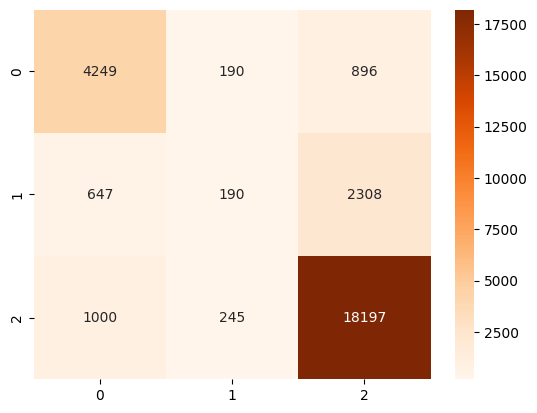

In [11]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


#Confusion matrix using pandas crosstab
conf_matrix = confusion_matrix(df_zero.score_cat, df_zero.category)
sns.heatmap(conf_matrix, annot=True, cmap=plt.cm.Oranges, fmt='g'); 

In [12]:
df_zero.to_csv("../data/ChatGPT-play-reviews-combined_zero.csv", index=False)

## VADER (Valence Aware Dictionary for Sentiment Reasoning)

Good to know:

VADER (Valence Aware Dictionary for Sentiment Reasoning) is a model used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion. It is available in the NLTK package and can be applied directly to unlabeled text data.

VADER sentimental analysis relies on a dictionary that maps lexical features to emotion intensities known as sentiment scores. The sentiment score of a text can be obtained by summing up the intensity of each word in the text.

For example, Words like ‘love’, ‘enjoy’, ‘happy’, ‘like’ all convey a positive sentiment. Also VADER is intelligent enough to understand the basic context of these words, such as “did not love” as a negative statement. It also understands the emphasis of capitalization and punctuation, such as “ENJOY”

Following code was inspired by the VADER documentation on Git:
https://github.com/cjhutto/vaderSentiment#code-examples

In [13]:
df_zero = pd.read_csv("../data/ChatGPT-play-reviews-combined_zero.csv",
                            encoding="utf-8",
                        )

df_zero.shape

(27922, 25)

In [14]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    #note: depending on how you installed (e.g., using source code download versus pip install), you may need to import like this:
    #from vaderSentiment import SentimentIntensityAnalyzer

In [17]:
from nltk import tokenize

#candidate_labels = list(category_map.values())
vad_cat = []
vad_neg = []
vad_neu = []
vad_pos = []
vad_comp = []

for sentence in tqdm(df_zero['content']):
     sid = SentimentIntensityAnalyzer()
     ss = sid.polarity_scores(sentence)
     for k in sorted(ss):
         vad_cat.append(max(ss, key=ss.get))
         vad_neg.append(ss['neg'])
         vad_neu.append(ss['neu'])
         vad_pos.append(ss['pos'])
         vad_comp.append(ss['compound'])

100%|██████████| 27922/27922 [03:21<00:00, 138.37it/s]


In [23]:
df_vader_prep = pd.DataFrame({ 'vader_cat': vad_cat, 
                               'vader_cmp': vad_comp, 
                                'vader_neg': vad_neg, 
                                'vader_neu': vad_neu, 
                                'vader_pos': vad_pos})
df_vader= pd.merge(df_zero, df_vader_prep, left_index=True, right_index=True)

In [24]:
df_vader.to_csv("../data/ChatGPT-play-reviews-zero-combined_vader.csv", index=False)

In [22]:
df_vader[146:147]

,Unnamed: 0,at,score,userName,content,Source,reviewId,thumbsUpCount,replyContent,repliedAt,...,score_cat,detected_language,category,positive_score,neutral_score,negative_score,vader_cat,vader_neg,vader_neu,vader_pos
146,146,2023-10-01,5,Chechnya Connected,i custom instructions for chatgpt️. hello i su...,Apple,NaN,NaN,NaN,NaN,...,positive,en,positive,0.967052,0.135006,0.00326,compound,0.084,0.777,0.139


## Sentiment Analysis using TextBlob

In [23]:
from textblob import TextBlob

Polarity determines the sentiment of the text. Its values lie in [-1,1] where -1 denotes a highly negative sentiment and 1 denotes a highly positive sentiment.

Subjectivity determines whether a text input is factual information or a personal opinion. Its value lies between [0,1] where a value closer to 0 denotes a piece of factual information and a value closer to 1 denotes a personal opinion.

In [24]:
#candidate_labels = list(category_map.values())
blob_polarity = []
blob_subjectivity = []

for sentence in tqdm(df['content']):
     blob_polarity.append(TextBlob(sentence).sentiment.polarity)
     blob_subjectivity.append(TextBlob(sentence).sentiment.subjectivity)

100%|██████████| 27922/27922 [00:07<00:00, 3798.47it/s]


In [25]:
df_blob_prep = pd.DataFrame({ 'blob_polarity': blob_polarity, 
                                    'blob_subjectivity': blob_subjectivity})
df_blob= pd.merge(df_vader, df_blob_prep, left_index=True, right_index=True)

In [26]:
df_blob.to_csv("../data/ChatGPT-play-reviews-combined_sentiment.csv", index=False)

## Sentiment Analysis using Transformer-Based Models

In [4]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [5]:
def strip_len(rev):
    content = rev[0:511]
    return content


In [6]:
df['content'] = df['content'].apply(strip_len)

In [7]:
#candidate_labels = list(category_map.values())
pipe_cat = []
pipe_neg = []
pipe_pos = []

for sentence in tqdm(df['content']):
     res = sentiment_pipeline(sentence)
     if res[0]['label'] == 'POSITIVE':
          pipe_cat.append('POSITIVE')
          pipe_neg.append(1-res[0]['score'])
          pipe_pos.append(res[0]['score'])
     elif res[0]['label'] == 'NEGATIVE':
          pipe_cat.append('NEGATIVE')
          pipe_neg.append(res[0]['score'])
          pipe_pos.append(1-res[0]['score'])

100%|██████████| 27922/27922 [14:02<00:00, 33.14it/s]


In [9]:
df_pipe_prep = pd.DataFrame({ 'pipe_cat': pipe_cat, 
                                    'pipe_neg': pipe_neg, 
                                    'pipe_pos': pipe_pos})

# Load df
df_blob = pd.read_csv(
    "../data/ChatGPT-play-reviews-combined_sentiment.csv"
)

df_pipe= pd.merge(df_blob, df_pipe_prep, left_index=True, right_index=True)

In [10]:
df_pipe

,at,score,userName,content,Source,reviewId,thumbsUpCount,replyContent,repliedAt,appVersion,...,negative_score,vader_cat,vader_neg,vader_neu,vader_pos,blob_polarity,blob_subjectivity,pipe_cat,pipe_neg,pipe_pos
0,2023-09-12,5,Tj77883344,love it been using it since last years very mu...,Apple,NaN,NaN,NaN,NaN,NaN,...,0.001162,compound,0.019,0.848,0.133,0.161817,0.426508,POSITIVE,0.002778,0.997222
1,2023-09-10,4,PDXJavaJunkie,much more accessible for blind users than the ...,Apple,NaN,NaN,NaN,NaN,NaN,...,0.077211,compound,0.019,0.848,0.133,0.206034,0.574713,NEGATIVE,0.986565,0.013435
2,2023-07-11,4,Tinny tower addicted,much anticipated wasn't let down i've been a u...,Apple,NaN,NaN,NaN,NaN,NaN,...,0.002238,compound,0.019,0.848,0.133,0.215267,0.549551,NEGATIVE,0.994540,0.005460
3,2023-05-27,4,Would Po,4.5 stars here's why i recently downloaded the...,Apple,NaN,NaN,NaN,NaN,NaN,...,0.005851,compound,0.019,0.848,0.133,0.275429,0.561762,NEGATIVE,0.996948,0.003052
4,2023-09-20,5,MORE FREE PAINTINGS!!!,always quick oh my gosh i cannot explain how m...,Apple,NaN,NaN,NaN,NaN,NaN,...,0.001967,compound,0.056,0.752,0.192,0.219267,0.675879,POSITIVE,0.000423,0.999577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27917,2023-07-25,5,Yeamin Hossain (Limon),first review,Google,6bed36cc-bc58-479e-b395-6644d15adeb8,0.0,NaN,NaN,NaN,...,0.675763,compound,0.000,0.742,0.258,0.250000,0.333333,POSITIVE,0.003007,0.996993
27918,2023-07-25,5,Sarvesh Soni,first downloaded,Google,2ecc7803-920c-4f95-8b15-db9c7b1caa8a,0.0,NaN,NaN,NaN,...,0.632305,compound,0.000,0.742,0.258,0.250000,0.333333,POSITIVE,0.110960,0.889040
27919,2023-07-25,5,mostafijur rahman,usually app,Google,0530373c-1bfc-45d2-9dec-9fc0bb9cff4d,0.0,NaN,NaN,NaN,...,0.367502,compound,0.000,0.742,0.258,-0.250000,0.250000,POSITIVE,0.028938,0.971062
27920,2023-07-25,5,Carter Gledhill,first comment,Google,4775c835-38dd-48b8-8bf0-c3f38fe8794d,0.0,NaN,NaN,NaN,...,0.659263,neu,0.063,0.881,0.056,0.250000,0.333333,POSITIVE,0.049670,0.950330


In [12]:
#df_pipe.drop(columns='Unnamed: 0', inplace=True)
df_pipe.to_csv("../data/ChatGPT-play-reviews-combined_sentiment.csv", index=False)

In [33]:
# Load df
df_pipe = pd.read_csv(
    "../data/ChatGPT-play-reviews-combined_sentiment.csv"
)


In [36]:
df

,at,score,userName,content,Source,reviewId,thumbsUpCount,replyContent,repliedAt,appVersion,...,category,positive_score,neutral_score,negative_score,vader_cat,vader_neg,vader_neu,vader_pos,blob_polarity,blob_subjectivity
0,2023-09-12,5,Tj77883344,love it been using it since last years very mu...,Apple,NaN,NaN,NaN,NaN,NaN,...,positive,0.999734,0.113145,0.001162,compound,0.019,0.848,0.133,0.161817,0.426508
1,2023-09-10,4,PDXJavaJunkie,much more accessible for blind users than the ...,Apple,NaN,NaN,NaN,NaN,NaN,...,positive,0.987289,0.079952,0.077211,compound,0.019,0.848,0.133,0.206034,0.574713
2,2023-07-11,4,Tinny tower addicted,much anticipated wasn't let down i've been a u...,Apple,NaN,NaN,NaN,NaN,NaN,...,positive,0.999699,0.012559,0.002238,compound,0.019,0.848,0.133,0.215267,0.549551
3,2023-05-27,4,Would Po,4.5 stars here's why i recently downloaded the...,Apple,NaN,NaN,NaN,NaN,NaN,...,positive,0.998542,0.137031,0.005851,compound,0.019,0.848,0.133,0.275429,0.561762
4,2023-09-20,5,MORE FREE PAINTINGS!!!,always quick oh my gosh i cannot explain how m...,Apple,NaN,NaN,NaN,NaN,NaN,...,positive,0.998937,0.143261,0.001967,compound,0.056,0.752,0.192,0.219267,0.675879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27917,2023-07-25,5,Yeamin Hossain (Limon),first review,Google,6bed36cc-bc58-479e-b395-6644d15adeb8,0.0,NaN,NaN,NaN,...,positive,0.816886,0.671854,0.675763,compound,0.000,0.742,0.258,0.250000,0.333333
27918,2023-07-25,5,Sarvesh Soni,first downloaded,Google,2ecc7803-920c-4f95-8b15-db9c7b1caa8a,0.0,NaN,NaN,NaN,...,positive,0.888082,0.590217,0.632305,compound,0.000,0.742,0.258,0.250000,0.333333
27919,2023-07-25,5,mostafijur rahman,usually app,Google,0530373c-1bfc-45d2-9dec-9fc0bb9cff4d,0.0,NaN,NaN,NaN,...,positive,0.846591,0.450016,0.367502,compound,0.000,0.742,0.258,-0.250000,0.250000
27920,2023-07-25,5,Carter Gledhill,first comment,Google,4775c835-38dd-48b8-8bf0-c3f38fe8794d,0.0,NaN,NaN,NaN,...,positive,0.815224,0.392924,0.659263,neu,0.063,0.881,0.056,0.250000,0.333333


In [47]:
df

,at,score,userName,content,Source,reviewId,thumbsUpCount,replyContent,repliedAt,appVersion,...,category,positive_score,neutral_score,negative_score,vader_cat,vader_neg,vader_neu,vader_pos,blob_polarity,blob_subjectivity
0,2023-09-12,5,Tj77883344,love it been using it since last years very mu...,Apple,NaN,NaN,NaN,NaN,NaN,...,positive,0.999734,0.113145,0.001162,compound,0.019,0.848,0.133,0.161817,0.426508
1,2023-09-10,4,PDXJavaJunkie,much more accessible for blind users than the ...,Apple,NaN,NaN,NaN,NaN,NaN,...,positive,0.987289,0.079952,0.077211,compound,0.019,0.848,0.133,0.206034,0.574713
2,2023-07-11,4,Tinny tower addicted,much anticipated wasn't let down i've been a u...,Apple,NaN,NaN,NaN,NaN,NaN,...,positive,0.999699,0.012559,0.002238,compound,0.019,0.848,0.133,0.215267,0.549551
3,2023-05-27,4,Would Po,4.5 stars here's why i recently downloaded the...,Apple,NaN,NaN,NaN,NaN,NaN,...,positive,0.998542,0.137031,0.005851,compound,0.019,0.848,0.133,0.275429,0.561762
4,2023-09-20,5,MORE FREE PAINTINGS!!!,always quick oh my gosh i cannot explain how m...,Apple,NaN,NaN,NaN,NaN,NaN,...,positive,0.998937,0.143261,0.001967,compound,0.056,0.752,0.192,0.219267,0.675879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27917,2023-07-25,5,Yeamin Hossain (Limon),first review,Google,6bed36cc-bc58-479e-b395-6644d15adeb8,0.0,NaN,NaN,NaN,...,positive,0.816886,0.671854,0.675763,compound,0.000,0.742,0.258,0.250000,0.333333
27918,2023-07-25,5,Sarvesh Soni,first downloaded,Google,2ecc7803-920c-4f95-8b15-db9c7b1caa8a,0.0,NaN,NaN,NaN,...,positive,0.888082,0.590217,0.632305,compound,0.000,0.742,0.258,0.250000,0.333333
27919,2023-07-25,5,mostafijur rahman,usually app,Google,0530373c-1bfc-45d2-9dec-9fc0bb9cff4d,0.0,NaN,NaN,NaN,...,positive,0.846591,0.450016,0.367502,compound,0.000,0.742,0.258,-0.250000,0.250000
27920,2023-07-25,5,Carter Gledhill,first comment,Google,4775c835-38dd-48b8-8bf0-c3f38fe8794d,0.0,NaN,NaN,NaN,...,positive,0.815224,0.392924,0.659263,neu,0.063,0.881,0.056,0.250000,0.333333
